In [21]:
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
!pip install lm-scorer
from lm_scorer.models.auto import AutoLMScorer
import torch
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

In [ ]:
scorer = AutoLMScorer.from_pretrained("gpt2-large", device='cuda')

In [3]:
sentences = pd.read_csv('../input/data/subtaskA_dev_data.csv', index_col=0)
labels = pd.read_csv('../input/data/subtaskA_gold_answers.csv', index_col=0, header=None)

In [ ]:
X_train = np.array([sentences['sent0'], sentences['sent1']]).T
y_train = np.array(labels)
X_test = np.array([sentences['sent0'], sentences['sent1']]).T
y_test = np.array(labels)

In [ ]:
def score(X, agg='prod'):
    return np.array([[scorer.sentence_score(x[0], reduce=agg), scorer.sentence_score(x[1], reduce=agg)] for x in X])

def predict(X, agg='prod'):
    scores = score(X, agg=agg)
    # the label is the "incorrect" sentence, so minimum probability
    return np.argmin(scores, axis=1)

In [ ]:
for agg in ('prod', 'hmean', 'gmean', 'mean'):
    y = predict(X_train, agg)
    print(accuracy_score(y, y_test))

In [ ]:
scores1 = scorer.sentence_score(sentences['sent0'].str.replace('  ', ' ').str.strip(), log=False, reduce='prod')
pd.Series(scores1).to_csv('scores1_prod.csv', header=None)

In [ ]:
scores2 = scorer.sentence_score(sentences['sent1'].str.replace('  ', ' ').str.strip(), log=False, reduce='prod')
pd.Series(scores2).to_csv('scores2_prod.csv', header=None)

In [9]:
prod_text = pd.read_csv('../input/gptttttt/GPT2_data_final_prod.csv', index_col='id')
prod_labels = pd.read_csv('../input/gptttttt/GPT2_answers_final_prod.csv', header=None, index_col=0)

gmean_text = pd.read_csv('../input/gpttttttt/GPT2_data_final.csv', index_col='id')
gmean_labels = pd.read_csv('../input/gpttttttt/GPT2_answers_final.csv', header=None, index_col=0)

In [10]:
prod_text['label'] = prod_labels
gmean_text['label'] = gmean_labels

In [11]:
prod_text['sent0'], prod_text['sent1'] = np.where(prod_text['label'] == 0, (prod_text['sent1'], prod_text['sent0']),
                                                 (prod_text['sent0'], prod_text['sent1']))

gmean_text['sent0'], gmean_text['sent1'] = np.where(gmean_text['label'] == 0, (gmean_text['sent1'], gmean_text['sent0']),
                                                 (gmean_text['sent0'], gmean_text['sent1']))


In [40]:
prod_text['length1'] = prod_text['sent0'].apply(lambda x: len(x.split(" ")))
prod_text['length2'] = prod_text['sent1'].apply(lambda x: len(x.split(" ")))

In [41]:
gmean_text['length1'] = gmean_text['sent0'].apply(lambda x: len(x.split(" ")))
gmean_text['length2'] = gmean_text['sent1'].apply(lambda x: len(x.split(" ")))

In [43]:
print(np.mean(prod_text['length1'][:5000]))
print(np.mean(prod_text['length2'][:5000]))

4.7898
5.004


In [44]:
print(np.mean(gmean_text['length1'][:5000]))
print(np.mean(gmean_text['length2'][:5000]))

8.3398
7.818


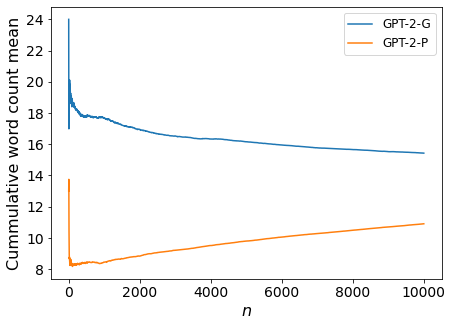

In [65]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 5))
plt.plot(np.arange(1, 10001), np.cumsum(gmean_text['length1'] + gmean_text['length2']) / np.arange(1, 10001), label='GPT-2-G')
plt.plot(np.arange(1, 10001), np.cumsum(prod_text['length1'] + prod_text['length2']) / np.arange(1, 10001), label='GPT-2-P')
plt.xlabel('$n$', fontsize=16)
plt.ylabel('Cummulative word count mean', fontsize=16)
plt.tick_params(labelsize=14)
plt.tick_params(labelsize=14)
plt.legend(fontsize=12)
plt.savefig('cummean')
